# Implementing distance constraint in ER
* We will not compare sequences i and j if |i-j| < 5

In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from ecc_tools import distance_restr

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

tools.hide_toggle()

### Read in Data

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('ID: ',pfam_id,' number of pdb structures:',npdb)

# Print PDB array 
print(pdb)
print(pdb[0])

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

ipdb = 0
print('seq:',int(pdb[ipdb,1]))

from data_processing import data_processing
# data processing
s0,cols_removed, s_index = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

print("Removed columns: ",cols_removed)

tools.hide_toggle()

ID:  PF00186  number of pdb structures: 372
[['PF00186' '69' 'Q5KZ26_GEOKA' ... 'B' '1' '160']
 ['PF00186' '69' 'Q5KZ26_GEOKA' ... 'A' '1' '160']
 ['PF00186' '83' 'Q81R22_BACAN' ... 'B' '2' '160']
 ...
 ['PF00186' '6952' 'DYR_MYCTU' ... 'A' '1' '158']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']
 ['PF00186' '7457' 'Q834R2_ENTFA' ... 'A' '1' '161']]
['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
seq: 69
Removed columns:  [  0   6  13  14 144 145  21  89  30 158 159  96  34  97  41  42  43  45
 114  53  56 123 127]


In [3]:
# number of positions
n_var = s0.shape[1]
#print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
#print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
#print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
#print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
#print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

tools.hide_toggle()

In [4]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
#print("Amino Acid sequence Matrix\n",s0)
#print("OneHot sequence Matrix\n",s)
#print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

tools.hide_toggle()

In [5]:
#------------- Define Distance Bounds --------------#
iL = np.zeros(s_index.shape,dtype=int)
iR = np.zeros(s_index.shape,dtype=int)
if s0.shape[1] != s_index.shape[0]:
    print("Print original index array size does not match sequence array size")
    exit(0);

print("s_index (length=%d):\n"%s_index.shape[0],s_index)
for i00, r_index in enumerate(s_index):
    #print("deining bounds for i0 = %d"%i0 0)
    # find left bound
    for ii in range(i00):
        #print("for %d, |%d - %d| = %d"%(ii,r_index,s_index[ii],abs(r_index-s_index[ii])))
        if abs(r_index - s_index[ii]) > 5:
            iL[i00] = ii
    # find right bound
    for ii in range(s_index.shape[0]-1,i00,-1):
        #print("for %d, |%d - %d| = %d"%(ii,r_index,s_index[ii],abs(r_index-s_index[ii])))
        if abs(r_index - s_index[ii]) > 5:
            iR[i00] = ii
#print("Left and Right bounds: ",iL,iR)
#---------------------------------------------------#

iLiR = np.stack([iL,iR]).T
print("\niLiR:",iLiR.shape,type(iLiR))
#print(iLiR)
tools.hide_toggle()

s_index (length=137):
 [  1   2   3   4   5   7   8   9  10  11  12  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  31  32  33  35  36  37  38  39  40  44  46
  47  48  49  50  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  90  91  92  93  94  95  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 115 116 117 118 119 120 121 122 124 125
 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 146
 147 148 149 150 151 152 153 154 155 156 157]

iLiR: (137, 2) <class 'numpy.ndarray'>


### First lets consider no distance constraint.
* Note: We have added a new output to data_processing: s_index 
    * Original index of processed referenece sequence data

In [6]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

# Expectation Reflection
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
#res = Parallel(n_jobs = 8)(delayed(predict_w)\
res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
#----------------niter_max,l2)
tools.hide_toggle()

run time: 423.9942472600087


In [7]:
for i0 in range(n_var):    
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
    h01 = res[i0][0]
    w1 = res[i0][1]
    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.

# Calculate Direct Information from infered weights and Original Sequence Data
di = direct_info(s0,w)
di_distal = distance_restr(di,s_index)

# Save w and di for future use
np.save('ER_w.npy',w)
np.save('ER_DI.npy',di)

tools.hide_toggle()

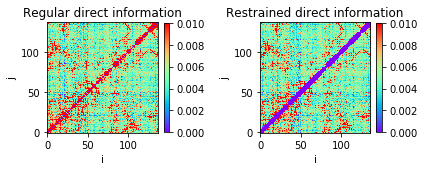

In [8]:
# Calculate the direct info sans distance restraint
# Calculate the direct info sans distance restraint
# Plot ROC for optimal distally constrained vs versus un-constrained ER
plt.subplot2grid((1,2),(0,0))
plt.title('Regular direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.subplot2grid((1,2),(0,1))
plt.title('Restrained direct information')
plt.imshow(di_distal,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.tight_layout(h_pad=1, w_pad=1.5)

tools.hide_toggle()

### Now we want to infer DI using DCA with same distal restraint

In [9]:
from inference_dca import direct_info_dca
DCA_di = direct_info_dca(s0)
DCA_di_distal = distance_restr(DCA_di,s_index)

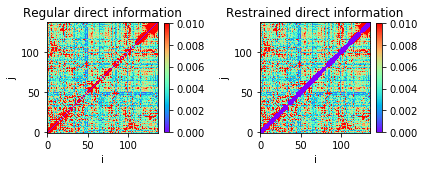

In [10]:
# Calculate the direct info sans distance restraint
# Calculate the direct info sans distance restraint
# Plot ROC for optimal distally constrained vs versus un-constrained ER
plt.subplot2grid((1,2),(0,0))
plt.title('Regular direct information')
plt.imshow(DCA_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.subplot2grid((1,2),(0,1))
plt.title('Restrained direct information')
plt.imshow(DCA_di_distal,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.tight_layout(h_pad=1, w_pad=1.5)

tools.hide_toggle()

## Compare Optimal DCA and ER (ct_thresh = 1.5 and 2. resp.)
* Not actually restricting distance for inferring data
* Taking the optimal threshold for each gives comparable accuracy
* ER Has higher accuracy for lower threshold

In [11]:
from ecc_tools import roc_curve
# find optimal threshold of distance for both DCA and ER
ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)

# We only want to plot i,j st |i-j|<5
ct_distal = np.zeros(ct.shape)                                                                           
print(ct_distal.shape)
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        if(abs(s_index[i]-s_index[j])<5):
            ct_distal[i][j]=ct.max()
        else:
            ct_distal[i][j] = ct[i][j]       
            
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc_DCA = np.zeros(n)
auc_ER = np.zeros(n)
for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,DCA_di_distal,ct_thres[i])
    auc_DCA[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_distal,di_distal,ct_thres[i])
    auc_ER[i] = tp.sum()/tp.shape[0]
    
i0_ER = np.argmax(auc_ER)
i0_DCA = np.argmax(auc_DCA)

print('DCA auc max:',ct_thres[i0_DCA],auc_DCA[i0_DCA])
p0_dca,tp0_dca,fp0_dca = tools.roc_curve(ct_distal,DCA_di_distal,ct_thres[i0_DCA])
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_er,tp0_er,fp0_er = tools.roc_curve(ct_distal,di_distal,ct_thres[i0_ER])

tools.hide_toggle()

Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 
(137, 137)
DCA auc max: 1.5 0.6152306737516245
ER auc max: 4.0 0.6269989980524825


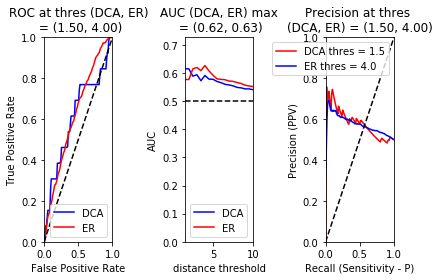

In [12]:
# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (DCA, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot(fp0_dca,tp0_dca,'b-',label="DCA")
plt.plot(fp0_er,tp0_er,'r-',label="ER")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (DCA, ER) max\n = (%3.2f, %3.2f)' %(auc_DCA[i0_DCA], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_DCA,'b-',label="DCA")
plt.plot(ct_thres,auc_ER,'r-',label="ER")
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,max(auc_ER.max(),auc_DCA.max())+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(DCA, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_DCA],ct_thres[i0_ER]))
plt.plot( p0_dca,tp0_dca/ (tp0_dca + fp0_dca),'r-',label='DCA thres = %s'%ct_thres[i0_DCA])
plt.plot( p0_er,tp0_er / (tp0_er + fp0_er),'b-',label='ER thres = %s'%ct_thres[i0_ER])
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()